# 7. BERT Regressor

Este notebook implementa um modelo de regressão utilizando o BERTimbau, uma versão do modelo BERT treinada para a língua portuguesa. O objetivo é prever o parâmetro `nu_param_B` a partir dos textos dos enunciados. O fluxo inclui etapas de pré-processamento, tokenização, divisão dos dados, treinamento do modelo e avaliação dos resultados.


In [1]:
# Importando dependências para BERT Regressor
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModel
from transformers.optimization import get_linear_schedule_with_warmup

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.nn.utils.clip_grad import clip_grad_norm_

In [2]:
# Leitura dos Dados
enem_data = pd.read_pickle("../data/final/enem_data_embeddings.pkl")
enem_data.dropna(subset=["nu_param_B", "enunciado", "alternativas"], inplace=True)
enem_data.head()

,numero_questao,gabarito,NU_PARAM_A,nu_param_B,NU_PARAM_C,ANO,enunciado,alternativas,gabarito_texto,distratores,...,distratores_embbedings_word2vec_100,similaridade_enunciado_gabarito_100,similaridade_enunciado_distratores_100,similaridade_gabarito_distratores_100,enunciado_embbedings_word2vec_50,gabarito_embbedings_word2vec_50,distratores_embbedings_word2vec_50,similaridade_enunciado_gabarito_50,similaridade_enunciado_distratores_50,similaridade_gabarito_distratores_50
0,1,C,3.43894,0.97831,0.10855,2017,"No império africano do Mali, no século XIV, To...",A: isolamento geográﬁco do Saara ocidental; B...,posição relativa nas redes de circulação,isolamento geográﬁco do Saara ocidental; explo...,...,"[-0.041815996, -0.06492707, 0.0900044, -0.0498...",0.141353,0.516898,0.151251,"[-0.017395772, -0.004402813, -0.046908338, 0.0...","[-0.16301225, -0.142375, 0.012171499, -0.00457...","[-0.041815996, -0.06492707, 0.0900044, -0.0498...",0.141353,0.516898,0.151251
1,2,D,3.00837,0.49169,0.13877,2017,Após a Declaração Universal dos Direitos Human...,A: ataque feito pelos japoneses à base milita...,execução de judeus e eslavos presos em guetos ...,ataque feito pelos japoneses à base militar am...,...,"[0.05533243, -0.039066706, -0.059438962, 0.019...",0.422576,0.313321,0.423611,"[-0.051949076, 0.03128451, -0.072241075, 0.028...","[-0.18672037, 0.04755275, -0.17406088, -0.0398...","[0.05533243, -0.039066706, -0.059438962, 0.019...",0.422576,0.313321,0.423611
2,3,D,0.60432,3.25992,0.08798,2017,"A moralidade, Bentham exortava, não é uma ques...",A: fundamentação cientíﬁca de viés positivist...,racionalidade de caráter pragmático,fundamentação cientíﬁca de viés positivista; c...,...,"[0.06667993, 0.015803386, 0.029443847, 0.11312...",0.427063,0.471643,0.602545,"[0.026049094, 0.043251127, -0.029757027, -0.00...","[0.011740998, 0.07592634, -0.016144669, 0.1384...","[0.06667993, 0.015803386, 0.029443847, 0.11312...",0.427063,0.471643,0.602545
3,4,E,1.85031,0.57925,0.11344,2017,Fala-se muito nos dias de hoje em direitos do ...,A: modernização da educação escolar; B: atuali...,universalização do princípio da igualdade civil,modernização da educação escolar; atualização ...,...,"[-0.07921684, 0.10788742, 0.10466367, -0.04121...",0.320939,0.482462,0.421501,"[-0.005251272, 0.039871164, -0.018038195, 0.06...","[-0.073669255, 0.12609875, 0.063628, 0.1261957...","[-0.07921684, 0.10788742, 0.10466367, -0.04121...",0.320939,0.482462,0.421501
4,5,C,2.46290,0.76307,0.17672,2017,Na Constituição da República Federativa do Bra...,A: etnia e miscigenação racial; B: sociedade...,espaço e sobrevivência cultural,etnia e miscigenação racial; sociedade e igual...,...,"[-0.02205533, 0.08129784, 0.10641242, -0.05484...",0.304050,0.501346,0.411802,"[0.01738678, 0.0033733728, -0.027247325, 0.002...","[0.11709199, -0.16062833, 0.082869664, -0.1195...","[-0.02205533, 0.08129784, 0.10641242, -0.05484...",0.304050,0.501346,0.411802


---
## 7.1. Funções Auxiliares

In [3]:
# Iniciando Tokenizer do BERT em Português
tokenizer = AutoTokenizer.from_pretrained(
    "neuralmind/bert-base-portuguese-cased", do_lower_case=False
)

In [34]:
# Convertendo os dados em DataLoader (Aceitos pelo Pytorch)
def create_dataloaders(inputs, masks, labels, batch_size):
    input_tensor = torch.tensor(inputs)
    mask_tensor = torch.tensor(masks)
    labels_tensor = torch.tensor(labels)

    dataset = TensorDataset(input_tensor, mask_tensor, labels_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

In [35]:
# Função para Calcular o R2
def r2_score(outputs, labels):
    labels_mean = torch.mean(labels)
    ss_tot = torch.sum((labels - labels_mean) ** 2)
    ss_res = torch.sum((labels - outputs) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2

In [36]:
# Função para treinamento do modelo BERT com Camada de Regressão
def train_bert(
    model,
    optimizer,
    scheduler,
    loss_function,
    epochs,
    train_dataloader,
    test_dataloader,
    device,
    clip_value=2,
):

    # Métricas de treino total (valor por época)
    loss_list = []
    rmse_list = []
    r2_train_list = []
    epoch_list = []

    # Métricas de teste total (valor por época)
    test_loss_list = []
    test_rmse_list = []
    r2_test_list = []

    best_loss = 1e10

    for epoch in range(epochs):
        # Métricas de treino em uma época (valor por batch)
        batch_loss_list = []
        batch_rmse_list = []
        train_preds = []
        train_labels = []

        print("\n--------")
        print("Epoch: ", epoch)

        model.train()
        for step, batch in enumerate(train_dataloader):
            batch_inputs, batch_masks, batch_labels = tuple(b.to(device) for b in batch)

            model.zero_grad()
            outputs = model(batch_inputs, batch_masks)

            loss = loss_function(outputs.squeeze(), batch_labels.squeeze())
            rmse = torch.sqrt(loss)

            loss.backward()
            clip_grad_norm_(model.parameters(), max_norm=clip_value)
            optimizer.step()
            scheduler.step()

            print(
                "   Batch: ",
                step,
                "    Loss:",
                loss.cpu().detach().numpy(),
                "    RMSE:",
                rmse.cpu().detach().numpy(),
            )

            batch_loss_list.append(loss)
            batch_rmse_list.append(rmse)
            epoch_list.append(epoch)

            # Salvando predições para R2
            train_preds.append(outputs.squeeze().detach())
            train_labels.append(batch_labels.squeeze().detach())

        # Calcular R2 de treino
        train_preds = torch.cat(train_preds)
        train_labels = torch.cat(train_labels)
        r2_train = r2_score(train_preds, train_labels)
        r2_train_list.append(r2_train)

        # Inicializa métricas de teste
        test_loss = 0
        test_rmse = 0
        test_preds = []
        test_labels = []

        model.eval()
        with torch.no_grad():
            for i, test_data in enumerate(test_dataloader):
                test_inputs, test_masks, batch_labels = tuple(
                    b.to(device) for b in test_data
                )
                test_outputs = model(test_inputs, test_masks)

                loss_item = loss_function(
                    test_outputs.squeeze(), batch_labels.squeeze()
                )
                test_loss += loss_item
                test_rmse += torch.sqrt(loss_item)

                test_preds.append(test_outputs.squeeze())
                test_labels.append(batch_labels.squeeze())

        # Calcular R² de teste
        test_preds = torch.cat(test_preds)
        test_labels = torch.cat(test_labels)
        r2_test = r2_score(test_preds, test_labels)
        r2_test_list.append(r2_test)

        # Cálculo das médias
        media_loss_treino = sum(batch_loss_list) / len(batch_loss_list)
        media_rmse_treino = sum(batch_rmse_list) / len(batch_rmse_list)
        loss_list.append(media_loss_treino)
        rmse_list.append(media_rmse_treino)

        media_loss_teste = test_loss / (i + 1)
        media_rmse_teste = test_rmse / (i + 1)
        test_loss_list.append(media_loss_teste)
        test_rmse_list.append(media_rmse_teste)

        if media_loss_treino < best_loss:
            best_loss = media_loss_treino
            torch.save(model.state_dict(), "bert_model.pht")

        print(
            "MSE Train: ",
            media_loss_treino.cpu().detach().numpy(),
            "  Test: ",
            media_loss_teste.cpu().detach().numpy(),
        )
        print(
            "RMSE Train: ",
            media_rmse_treino.cpu().detach().numpy(),
            "  Test: ",
            media_rmse_teste.cpu().detach().numpy(),
        )
        print(
            "R2 Train: ",
            r2_train.cpu().detach().numpy(),
            "  Test: ",
            r2_test.cpu().detach().numpy(),
        )

    return (
        model,
        loss_list,
        rmse_list,
        test_loss_list,
        test_rmse_list,
        r2_train_list,
        r2_test_list,
        best_loss,
    )

---
## 7.2. Modelo com Enunciado

In [4]:
data = enem_data[["enunciado", "nu_param_B"]]
data.head()

,enunciado,nu_param_B
0,"No império africano do Mali, no século XIV, To...",0.97831
1,Após a Declaração Universal dos Direitos Human...,0.49169
2,"A moralidade, Bentham exortava, não é uma ques...",3.25992
3,Fala-se muito nos dias de hoje em direitos do ...,0.57925
4,Na Constituição da República Federativa do Bra...,0.76307


### 7.2.1. Tokenização (*BERTimbau*)

In [ ]:
# Tokenizando os textos do enunciado
encoded_corpus = tokenizer(
    text=data.enunciado.tolist(),
    add_special_tokens=True,
    padding="max_length",
    truncation="longest_first",
    max_length=512,
    return_attention_mask=True,
)

# Coletando input_ids (features)
input_ids = encoded_corpus["input_ids"]
attention_mask = encoded_corpus["attention_mask"]

# Coletando labels (target)
labels = data.nu_param_B.to_numpy()

In [ ]:
# Separando dados para validação (20% para validação / 80% para treino e teste)
seed = 42

train_and_test_inputs, val_inputs, train_and_test_labels, val_labels = train_test_split(
    input_ids, labels, test_size=0.2, random_state=seed
)
train_and_test_masks, val_masks, _, _ = train_test_split(
    attention_mask, labels, test_size=0.2, random_state=seed
)

In [ ]:
# Separando treino e teste (10% dos dados para teste/ 90% para treino)

train_inputs, test_inputs, train_labels, test_labels = train_test_split(
    train_and_test_inputs, train_and_test_labels, test_size=0.1, random_state=seed
)
train_masks, test_masks, _, _ = train_test_split(
    train_and_test_masks, train_and_test_labels, test_size=0.1, random_state=seed
)

In [ ]:
batch_size = 8

train_dataloader = create_dataloaders(
    train_inputs, train_masks, train_labels, batch_size
)
test_dataloader = create_dataloaders(test_inputs, test_masks, test_labels, batch_size)

### 7.2.2. Criando Camada de Regressão no BERT


In [ ]:
# Definindo classe Bert + Camada de Regressão
class BertimbauRegressor(nn.Module):

    def __init__(self, drop_rate=0.2, freeze_bertimbau=False):
        super(BertimbauRegressor, self).__init__()
        D_in, D_out = 768, 1

        # Pre-trained BERTimbau Neural Network
        self.bertimbau = AutoModel.from_pretrained(
            "neuralmind/bert-base-portuguese-cased"
        )

        # Regressor Layer (Takes 768 input from pre-trained BERT and outputs one value)
        self.regressor = nn.Sequential(nn.Dropout(drop_rate), nn.Linear(D_in, D_out))
        self.double()

    def forward(self, input_ids, attention_masks):
        outputs = self.bertimbau(input_ids=input_ids, attention_mask=attention_masks)
        class_label_output = outputs[1]
        outputs = self.regressor(class_label_output)
        return outputs

In [ ]:
# Iniciando Modelo Bertimbau Regressor
model = BertimbauRegressor(drop_rate=0.2)

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

### 7.2.3. Configurando Ambiente de Treinamento


In [ ]:
torch.cuda.empty_cache()

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Training on GPU: {torch.cuda.get_device_name(0)}")
else:
    print(f"No GPU available, using CPU.")
    device = torch.device("cpu")

Training on GPU: Tesla T4


In [ ]:
model.to(device)

BertimbauRegressor(
  (bertimbau): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29794, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, e

### 7.2.4. Treinamento


In [ ]:
# Definindo o otimizador como o BERT original
optimizer = torch.optim.AdamW(
    model.parameters(), lr=3e-5, eps=1e-8
)  # Same as BERT Paper

# MSE loss is the most common for Regression Tasks
loss_function = nn.MSELoss()

# Definindo número de épocas
epochs = 8
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=total_steps
)

# Treinamento
(
    model,
    loss_list,
    rmse_list,
    test_loss_list,
    test_rmse_list,
    r2_train_list,
    r2_test_list,
    best_loss,
) = train_bert(
    model,
    optimizer,
    scheduler,
    loss_function,
    epochs,
    train_dataloader,
    test_dataloader,
    device,
    clip_value=2,
)


--------
Epoch:  0
   Batch:  0     Loss: 1.7975769014587648     RMSE: 1.3407374468771895
   Batch:  1     Loss: 1.6554226330158728     RMSE: 1.2866322835277657
   Batch:  2     Loss: 0.5272418289931453     RMSE: 0.7261141983139741
   Batch:  3     Loss: 1.0828293703690233     RMSE: 1.040590875593777
   Batch:  4     Loss: 0.5422984720090254     RMSE: 0.7364091743107397
   Batch:  5     Loss: 0.7344234259859916     RMSE: 0.8569850792084956
   Batch:  6     Loss: 0.8838453982340068     RMSE: 0.9401305219138494
   Batch:  7     Loss: 0.522513531695957     RMSE: 0.7228509747492612
   Batch:  8     Loss: 0.5475183118991968     RMSE: 0.7399448032787289
   Batch:  9     Loss: 0.7658126547686286     RMSE: 0.8751072247265638
   Batch:  10     Loss: 0.7403156949002896     RMSE: 0.860416001071743
   Batch:  11     Loss: 0.3427180453976757     RMSE: 0.5854212546514481
   Batch:  12     Loss: 0.4791025280226622     RMSE: 0.6921723253805097
   Batch:  13     Loss: 0.3677496791264994     RMSE: 0.60

### 7.2.5. Resultados

In [ ]:
print("Melhor RMSE de Treino: ", min(rmse_list).cpu().detach().numpy())
print("Melhor RMSE de Teste: ", min(test_rmse_list).cpu().detach().numpy())
print("Melhor R2 de Treino: ", max(r2_train_list).cpu().detach().numpy())
print("Melhor R2 de Teste: ", max(r2_test_list).cpu().detach().numpy())

Melhor RMSE de Treino:  0.19217618024753128
Melhor RMSE de Teste:  0.5545048397888243
Melhor R2 de Treino:  0.9136535062628718
Melhor R2 de Teste:  0.2919035201600636


In [ ]:
loss_list_complete = []
rmse_list_complete = []
r2_list_complete = []
test_loss_list_complete = []
test_rmse_list_complete = []
test_r2_list_complete = []

for value in loss_list:
    loss_list_complete.append(float(value.cpu().detach().numpy()))

for value in rmse_list:
    rmse_list_complete.append(float(value.cpu().detach().numpy()))

for value in r2_train_list:
    r2_list_complete.append(float(value.cpu().detach().numpy()))

for value in test_loss_list:
    test_loss_list_complete.append(float(value.cpu().detach().numpy()))

for value in test_rmse_list:
    test_rmse_list_complete.append(float(value.cpu().detach().numpy()))

for value in r2_test_list:
    test_r2_list_complete.append(float(value.cpu().detach().numpy()))

In [ ]:
dict_results = {
    "loss_list": loss_list_complete,
    "rmse_list": rmse_list_complete,
    "r2_list": r2_list_complete,
    "test_loss_list": test_loss_list_complete,
    "test_rmse_list": test_rmse_list_complete,
    "test_r2_list": test_r2_list_complete,
}
df_results = pd.DataFrame(dict_results)

df_results.head(3)

,loss_list,rmse_list,r2_list,test_loss_list,test_rmse_list,test_r2_list
0,0.657615,0.771086,-0.317166,0.417079,0.627646,0.072447
1,0.400164,0.601647,0.202602,0.322585,0.554505,0.286643
2,0.278692,0.512403,0.447287,0.331356,0.571597,0.273643


In [ ]:
df_results.to_pickle("df_results.pkl")

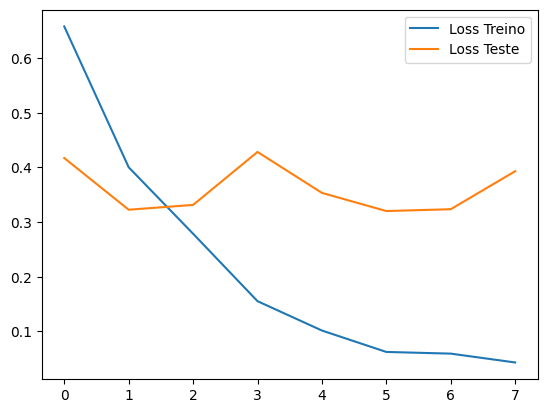

In [ ]:
plt.plot(loss_list_complete, label="Loss Treino")
plt.plot(test_loss_list_complete, label="Loss Teste")
plt.legend()
plt.show()

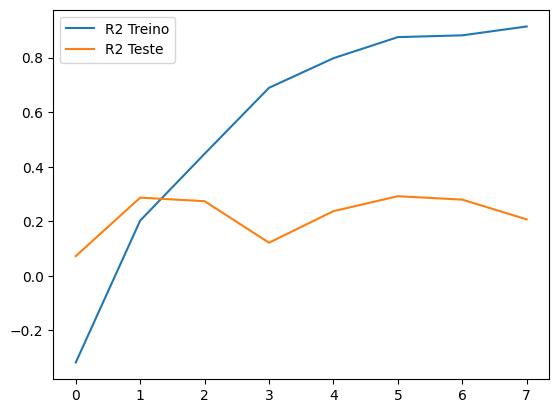

In [ ]:
plt.plot(r2_list_complete, label="R2 Treino")
plt.plot(test_r2_list_complete, label="R2 Teste")
plt.legend()
plt.show()

## 7.3. Modelo com Enunciado e Alternativas


In [37]:
data = enem_data[["enunciado", "alternativas", "nu_param_B"]]
data.head()

,enunciado,alternativas,nu_param_B
0,"No império africano do Mali, no século XIV, To...",A: isolamento geográﬁco do Saara ocidental; B...,0.97831
1,Após a Declaração Universal dos Direitos Human...,A: ataque feito pelos japoneses à base milita...,0.49169
2,"A moralidade, Bentham exortava, não é uma ques...",A: fundamentação cientíﬁca de viés positivist...,3.25992
3,Fala-se muito nos dias de hoje em direitos do ...,A: modernização da educação escolar; B: atuali...,0.57925
4,Na Constituição da República Federativa do Bra...,A: etnia e miscigenação racial; B: sociedade...,0.76307


### 7.3.1. Tokenização (_BERTimbau_)


In [38]:
input_text = [
    f"{enunciado} {alternativa}"
    for enunciado, alternativa in zip(
        data.enunciado.tolist(), data.alternativas.tolist()
    )
]
input_text[:5]

['No império africano do Mali, no século XIV, Tombuctu foi centro de um comércio internacional onde tudo era negociado — sal, escravos, marﬁm etc. Havia também um grande comércio de livros de história, medicina, astronomia e matemática, além de grande concentração de estudantes. A importância cultural de Tombuctu pode ser percebida por meio de um velho provérbio: “O sal vem do norte, o ouro vem do sul, mas as palavras de Deus e os tesouros da sabedoria vêm de Tombuctu”.Uma explicação para o dinamismo dessa cidade e sua importância histórica no período mencionado era o(a) A:  isolamento geográﬁco do Saara ocidental; B:  exploração intensiva de recursos naturais; C:  posição relativa nas redes de circulação; D:  tráﬁco transatlântico de mão de obra servil; E:  competição econômica dos reinos da região',
 'Após a Declaração Universal dos Direitos Humanos pela ONU, em 1948, a Unesco publicou estudos de cientistas de todo o mundo que desqualiﬁcaram as doutrinas racistas e demonstraram a uni

In [39]:
# Tokenizando os textos do enunciado
encoded_corpus = tokenizer(
    text=input_text,
    add_special_tokens=True,
    padding="max_length",
    truncation="longest_first",
    max_length=512,
    return_attention_mask=True,
)

# Coletando input_ids (features)
input_ids = encoded_corpus["input_ids"]
attention_mask = encoded_corpus["attention_mask"]

# Coletando labels (target)
labels = data.nu_param_B.to_numpy()

In [40]:
# Separando dados para validação (20% para validação / 80% para treino e teste)
seed = 42

train_and_test_inputs, val_inputs, train_and_test_labels, val_labels = train_test_split(
    input_ids, labels, test_size=0.2, random_state=seed
)
train_and_test_masks, val_masks, _, _ = train_test_split(
    attention_mask, labels, test_size=0.2, random_state=seed
)

In [41]:
# Separando treino e teste (10% dos dados para teste/ 90% para treino)

train_inputs, test_inputs, train_labels, test_labels = train_test_split(
    train_and_test_inputs, train_and_test_labels, test_size=0.1, random_state=seed
)
train_masks, test_masks, _, _ = train_test_split(
    train_and_test_masks, train_and_test_labels, test_size=0.1, random_state=seed
)

In [42]:
batch_size = 8

train_dataloader = create_dataloaders(
    train_inputs, train_masks, train_labels, batch_size
)
test_dataloader = create_dataloaders(test_inputs, test_masks, test_labels, batch_size)

### 7.3.2. Criando Camada de Regressão no BERT


In [43]:
# Definindo classe Bert + Camada de Regressão
class BertimbauRegressor(nn.Module):

    def __init__(self, drop_rate=0.2, freeze_bertimbau=False):
        super(BertimbauRegressor, self).__init__()
        D_in, D_out = 768, 1

        # Pre-trained BERTimbau Neural Network
        self.bertimbau = AutoModel.from_pretrained(
            "neuralmind/bert-base-portuguese-cased"
        )

        # Regressor Layer (Takes 768 input from pre-trained BERT and outputs one value)
        self.regressor = nn.Sequential(nn.Dropout(drop_rate), nn.Linear(D_in, D_out))
        self.double()

    def forward(self, input_ids, attention_masks):
        outputs = self.bertimbau(input_ids=input_ids, attention_mask=attention_masks)
        class_label_output = outputs[1]
        outputs = self.regressor(class_label_output)
        return outputs

In [44]:
# Iniciando Modelo Bertimbau Regressor
model = BertimbauRegressor(drop_rate=0.2)

### 7.3.3. Configurando Ambiente de Treinamento


In [45]:
torch.cuda.empty_cache()

In [46]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Training on GPU: {torch.cuda.get_device_name(0)}")
else:
    print(f"No GPU available, using CPU.")
    device = torch.device("cpu")

Training on GPU: Tesla T4


In [47]:
model.to(device)

BertimbauRegressor(
  (bertimbau): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29794, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, e

### 7.3.4. Treinamento


In [48]:
# Definindo o otimizador como o BERT original
optimizer = torch.optim.AdamW(
    model.parameters(), lr=3e-5, eps=1e-8
)  # Same as BERT Paper

# MSE loss is the most common for Regression Tasks
loss_function = nn.MSELoss()

# Definindo número de épocas
epochs = 8
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=total_steps
)

# Treinamento
(
    model,
    loss_list,
    rmse_list,
    test_loss_list,
    test_rmse_list,
    r2_train_list,
    r2_test_list,
    best_loss,
) = train_bert(
    model,
    optimizer,
    scheduler,
    loss_function,
    epochs,
    train_dataloader,
    test_dataloader,
    device,
    clip_value=2,
)


--------
Epoch:  0
   Batch:  0     Loss: 1.373850454644037     RMSE: 1.1721136696771508
   Batch:  1     Loss: 0.5055075385559532     RMSE: 0.7109905333799833
   Batch:  2     Loss: 0.2748702539067266     RMSE: 0.5242807014441087
   Batch:  3     Loss: 1.2667444623054296     RMSE: 1.1254974288311055
   Batch:  4     Loss: 0.6933357359732251     RMSE: 0.8326678425237911
   Batch:  5     Loss: 0.48314323166634454     RMSE: 0.695085053548373
   Batch:  6     Loss: 0.4945302319342707     RMSE: 0.7032284351007649
   Batch:  7     Loss: 0.7514183482599636     RMSE: 0.8668439007456669
   Batch:  8     Loss: 0.23110995751150373     RMSE: 0.48073897024425194
   Batch:  9     Loss: 0.34980711145556614     RMSE: 0.5914449352691814
   Batch:  10     Loss: 0.3908102782495569     RMSE: 0.6251482050278613
   Batch:  11     Loss: 0.4059595046345276     RMSE: 0.6371495151332438
   Batch:  12     Loss: 1.2064736938581917     RMSE: 1.0983959640576761
   Batch:  13     Loss: 0.17025108938381905     RMSE

### 7.3.5. Resultados

In [50]:
print("Melhor RMSE de Treino: ", min(rmse_list).cpu().detach().numpy())
print("Melhor RMSE de Teste: ", min(test_rmse_list).cpu().detach().numpy())
print("Melhor R2 de Treino: ", max(r2_train_list).cpu().detach().numpy())
print("Melhor R2 de Teste: ", max(r2_test_list).cpu().detach().numpy())

Melhor RMSE de Treino:  0.18647577402223195
Melhor RMSE de Teste:  0.5688063459774907
Melhor R2 de Treino:  0.919139245957697
Melhor R2 de Teste:  0.3083193331748706


In [51]:
loss_list_complete = []
rmse_list_complete = []
r2_list_complete = []
test_loss_list_complete = []
test_rmse_list_complete = []
test_r2_list_complete = []

for value in loss_list:
    loss_list_complete.append(float(value.cpu().detach().numpy()))

for value in rmse_list:
    rmse_list_complete.append(float(value.cpu().detach().numpy()))

for value in r2_train_list:
    r2_list_complete.append(float(value.cpu().detach().numpy()))

for value in test_loss_list:
    test_loss_list_complete.append(float(value.cpu().detach().numpy()))

for value in test_rmse_list:
    test_rmse_list_complete.append(float(value.cpu().detach().numpy()))

for value in r2_test_list:
    test_r2_list_complete.append(float(value.cpu().detach().numpy()))

In [52]:
dict_results = {
    "loss_list": loss_list_complete,
    "rmse_list": rmse_list_complete,
    "r2_list": r2_list_complete,
    "test_loss_list": test_loss_list_complete,
    "test_rmse_list": test_rmse_list_complete,
    "test_r2_list": test_r2_list_complete,
}
df_results = pd.DataFrame(dict_results)

df_results.head(3)

,loss_list,rmse_list,r2_list,test_loss_list,test_rmse_list,test_r2_list
0,0.563026,0.717342,-0.125470,0.409020,0.634377,0.122069
1,0.441026,0.634029,0.120168,0.328008,0.568806,0.308319
2,0.272276,0.495744,0.455207,0.395733,0.627030,0.173997


In [53]:
df_results.to_pickle("df_results.pkl")

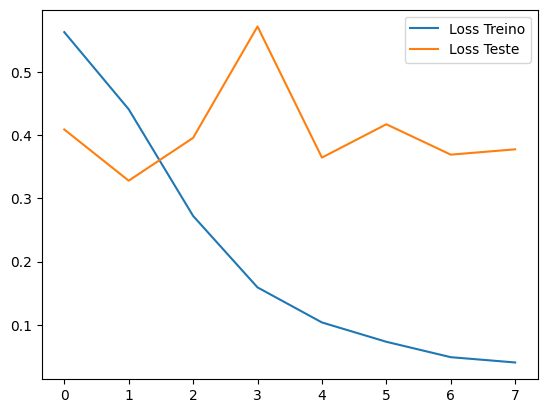

In [54]:
import matplotlib.pyplot as plt

plt.plot(loss_list_complete, label="Loss Treino")
plt.plot(test_loss_list_complete, label="Loss Teste")
plt.legend()
plt.show()

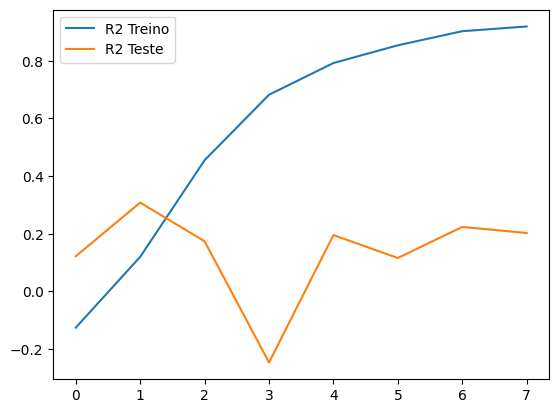

In [55]:
plt.plot(r2_list_complete, label="R2 Treino")
plt.plot(test_r2_list_complete, label="R2 Teste")
plt.legend()
plt.show()

---